In [128]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs

In [202]:
## kmeans++ algorithm for seeding initial centroids before kmeans clustering
# parameters: X (data set), k (number of clusters)
# returns: centroids (array of initial cluster centers)
def kmeans_pp(X, k):
    # randomly choose first centroid from X
    rand_int = random.randint(0, np.size(X,0)-1)
    centroids = np.array([X[rand_int]])
    # remove already selected centroid from dataset X
    X = np.delete(X,rand_int,axis=0)
    # for each remaining centroid, do
    for c in range(1, k):
        # get min L2 distance (squared) from each data point in X to nearest centroid (thats already chosen)
        Dx = np.array([min([np.linalg.norm(x-c)**2 for c in centroids]) for x in X])
        # get weighted probability distribution of each data point wrt Dx^2
        probs = Dx / np.sum(Dx)
        # get cumulative probability of probs 
        cumprobs = np.cumsum(probs)
        # pick data point from X to be next center at random using weighted probs dist wrt Dx^2
        r = random.random()
        ind = np.where(cumprobs >= r)[0][0]
        centroids = np.append(centroids, [X[ind]], axis=0)
        X = np.delete(X,ind,axis=0)
    return centroids

In [177]:
## generate k centroids for all clusters in dataset
# parameters: Nxp dataset X and int k
# returns: kxp array of centroids (each row is a centroid with p features)
def k_means(X, k, maxIters):
    # initialize k centroids using kmeans++
    seeds = kmeans_pp(X, k)
    centroids = seeds
    iters=0
    stopLoop = False
    
    # keep iterating until max iterations reached or no change in centroid updates
    while (iters < maxIters) and (not stopLoop):
        iters = iters + 1
        # stores sum of all data points belonging to each cluster
        cluster_sum = np.zeros(centroids.shape, dtype='float64')
        # stores cluster assignments for each data point in X
        cluster_assgnmt = np.zeros(np.size(X,0), dtype='int64')
        
        # loop through entire dataset X
        for i,data_point in enumerate(X):
            # calculate Euclidean L2 distance of data point from each of the k centroids
            distances = np.linalg.norm(data_point - centroids, axis=1)
            # find index of closest centroid to current data point
            min_index = np.argmin(distances)
            # save min_index assignment for each data point
            cluster_assgnmt[i] = min_index
            # update sum of all data points belonging to this cluster
            cluster_sum[min_index] += data_point

        # get total number of data points for each cluster
        cluster_count = np.bincount(cluster_assgnmt, minlength=k)
        # new centroids are means of sum/count for each cluster (add new axis to count vector to allow broadcasting)
        new_centroids = cluster_sum / cluster_count[:,None]
        # calculate the L2 distance between new and old centroids
        L2_distances = np.linalg.norm(centroids - new_centroids, axis=1)
        # update centroids
        centroids = new_centroids
        # if all L2 distance is <= 0.001 (no centroids change), stop iterating
        if np.any(L2_distances <= 0.001):
            stopLoop = True
    
    return seeds, centroids, iters, cluster_assgnmt

In [132]:
## plot 2d dataset and centroids
def plot_clusters_2d(X, centroids, cluster_labels, title):
    # color each cluster differently, using cluster indices as labels
    label_color_map = {  0:'c',
                         1:'y',
                         2:'k',
                         3:'b',
                         4:'g',
                         5:'m',  
                         6:'purple',
                         7:'pink',
                         8:'olive',
                         9:'orange',
                         10:'lime',
                         11:'gray',
                         12:'brown'
                      }
    # retreive color label for each data point from map above, using assigned cluster labels as key
    label_color = [label_color_map[l] for l in cluster_labels]
    # create scatter plot of data and centroids
    fig, ax = plt.subplots()
    ax.scatter(X[:,0], X[:,1], color=label_color, s=5)
    ax.scatter(centroids[:,0], centroids[:,1], color='r', marker="*", s=50)
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

In [133]:
## plot 3d dataset and centroids
def plot_clusters_3d(X, centroids, cluster_labels, title):
    # color each cluster differently, using cluster indices as labels
    label_color_map = {  0:'c',
                         1:'y',
                         2:'k',
                         3:'b',
                         4:'g',
                         5:'m',  
                         6:'purple',
                         7:'pink',
                         8:'olive',
                         9:'orange',
                         10:'lime',
                         11:'gray',
                         12:'brown'
                      }
    # retreive color label for each data point from map above, using assigned cluster lebels
    label_color = [label_color_map[l] for l in cluster_labels]
    # create scatter plot of data and centroids
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(X[:,0], X[:,1], X[:,2], color=label_color, s=5)
    ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], color='k', marker="*", s=250)
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')

In [134]:
## Uses sci-kit learn's built-in kmeans function to cluster data
# parameters: dataset X, number of clusters k, max iterations maxIter
# returns: final centroids, number of iterations ran, cluster assignment labels
def sklearn_kmeans(X, k, maxIter):  
    # specify kmeans parameters
    kmeans = KMeans(n_clusters=k, 
                    max_iter=maxIter)
    # Fitting the input data
    kmeans = kmeans.fit(X)
    # Getting the cluster labels
    labels = kmeans.predict(X)
    # Final centroid values
    centroids = kmeans.cluster_centers_
    # Number of iterations run
    iters = kmeans.n_iter_    
    return centroids, iters, labels

In [209]:
# Runs 2 kmeans implementations on data to cluster it - my kmeans from scratch function, vs sci-kit learn's built in kmeans function
# parameter: dataset N, number of dimensions (features) of data, number of clusters k, maximum iterations to run maxIter
# returns: void (prints iterations ran, centroid values and various plots of clusters)
def compare_kmeans(N, d, k, maxIter):
    # Creating a sample dataset with k clusters
    X, y = make_blobs(n_samples=N, 
                      n_features=d, 
                      centers=k)
    # specify maximum iterations to run
    maxIter=maxIter
    # do k means clustering from scratch
    seeds, centroids, iters, cluster_labels = k_means(X, k, maxIter)
    # do k means clustering using built-in scikit-learn built in kmeans
    sklearn_centroids, sklearn_iters, sklearn_labels = sklearn_kmeans(X, k, maxIter)

    # for 3D data
    if d==3:  
        # plot original data set with initial centroid seeds
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.set_title("Original Data with Initial Seeds")
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, s=2)
        ax.scatter(seeds[:, 0], seeds[:, 1], seeds[:, 2], c='k', marker="*", s=150)
        # plot clusters from my kmeans & sklearn kmeans
        plot_clusters_3d(X, centroids, cluster_labels, 'From Scratch')
        plot_clusters_3d(X, sklearn_centroids, sklearn_labels, 'Sci-kit Learn (Built-In)')
    # for 2D data
    else:
        # plot original data set with initial centroid seeds
        fig, ax = plt.subplots()
        ax.set_title("Original Data with Initial Seeds")
        ax.scatter(X[:, 0], X[:, 1], c=y, s=2)
        ax.scatter(seeds[:, 0], seeds[:, 1], c='k', marker="*", s=150)
        # plot clusters from my kmeans & sklearn kmeans
        plot_clusters_2d(X, centroids, cluster_labels, 'From Scratch')
        plot_clusters_2d(X, sklearn_centroids, sklearn_labels, 'Sci-kit Learn (Built-In)')

    # Compare from_scratch vs sklearn
    print("My iterations: ", iters)
    print("My centroids: \n", centroids)
    print("------------------------------------")
    print("SKLearn iterations: ", sklearn_iters)
    print("SKLearn centroids: \n", sklearn_centroids)

My iterations:  2
My centroids: 
 [[-9.63515223  9.99168131 -4.69025526]
 [-8.15068686  3.74611924  7.69236524]
 [-5.2494331   6.026436   -4.78049211]
 [-8.11776492 -3.82481021 -7.2386713 ]
 [-8.5234823  -9.0261299   5.28779808]]
------------------------------------
SKLearn iterations:  2
SKLearn centroids: 
 [[-9.63515223  9.99168131 -4.69025526]
 [-8.5234823  -9.0261299   5.28779808]
 [-8.11776492 -3.82481021 -7.2386713 ]
 [-8.15068686  3.74611924  7.69236524]
 [-5.2494331   6.026436   -4.78049211]]


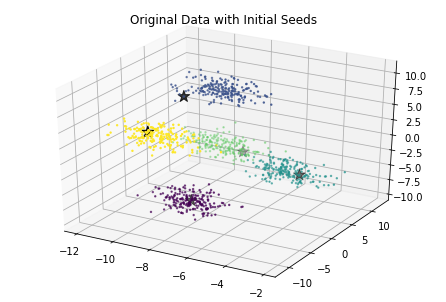

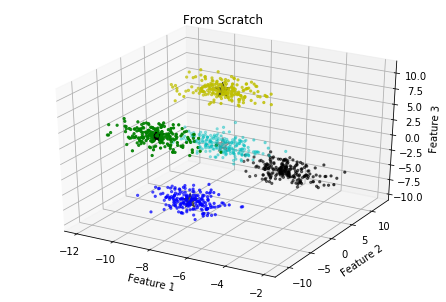

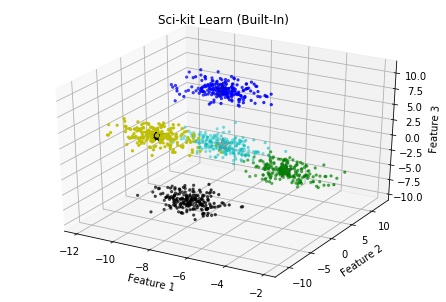

In [213]:
compare_kmeans(
    N=1000,
    d=3,
    k=5,
    maxIter=10000)